# MEMDET Benchmark

In [1]:
# Import packages
import numpy
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

import os
from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter

import texplot
texplot.set_theme()

# import seaborn as sns
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{xfrac}'
# #matplotlib.font_manager._rebuild()
# sns.set(font_scale=1.15)
# sns.set_style("white")
# sns.set_style("ticks")
# plt.rc('font', family='serif')
# plt.rcParams['svg.fonttype'] = 'none'

In [2]:
# Read data

benchmark_dir = '.'
base_filename = 'benchmark-memdet'

# Read file
results_filename = join(benchmark_dir, base_filename + '.pickle')
with open(results_filename, 'rb') as file:
    benchmark_results = pickle.load(file)

detkit_config = benchmark_results['detkit_config']
config = benchmark_results['config']
devices = benchmark_results['devices']
results = benchmark_results['results']

# Unpack config
matrix_sizes = config['matrix_sizes']
num_blocks = config['num_blocks']
num_repeats = config['num_repeats']

# Unpack results
tot_wall_time = results['tot_wall_time']
tot_proc_time = results['tot_proc_time']
load_wall_time = results['load_wall_time']
load_proc_time = results['load_proc_time']
store_wall_time = results['store_wall_time']
store_proc_time = results['store_proc_time']

scratch_nbytes = results['scratch_nbytes']

matrix_blocks = results['matrix_blocks']
block_size = results['block_size']
num_block_loads = results['num_block_loads']
num_block_stores = results['num_block_stores']

alloc_mem = results['alloc_mem']
alloc_mem_peak = results['alloc_mem_peak']
total_mem = results['total_mem']
total_mem_peak = results['total_mem_peak']

lds = results['lds']
signs = results['signs']

Text(0, 0.5, 'sign')

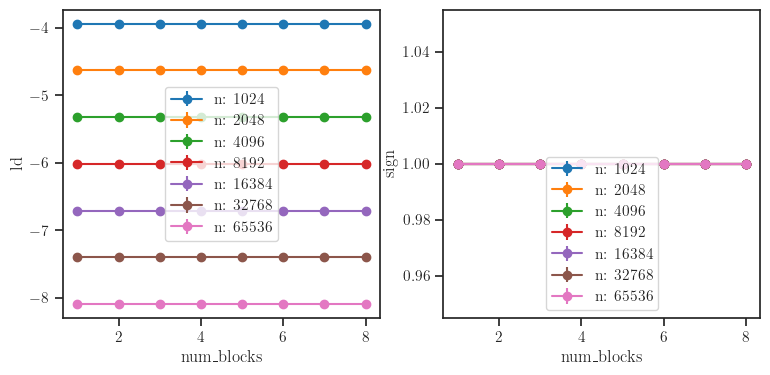

In [3]:
# Check ls and sign
fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
for i in range(matrix_sizes.size):
    ax[0].errorbar(num_blocks,
                   numpy.mean(lds[i, :, :]/matrix_sizes[i], axis=-1),
                   yerr=numpy.std(lds[i, :, :]/matrix_sizes[i], axis=-1),
                   fmt='-o', label=f'n: {matrix_sizes[i]}')
    ax[1].errorbar(num_blocks,
                   numpy.mean(signs[i, :, :], axis=-1),
                   yerr=numpy.std(signs[i, :, :], axis=-1),
                   fmt='-o', label=f'n: {matrix_sizes[i]}')

ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('num_blocks')
ax[1].set_xlabel('num_blocks')
ax[0].set_ylabel('ld')
ax[1].set_ylabel('sign')

Plot saved to "/home/sia/work/github/detkit/benchmark/memdet/performance.pdf".


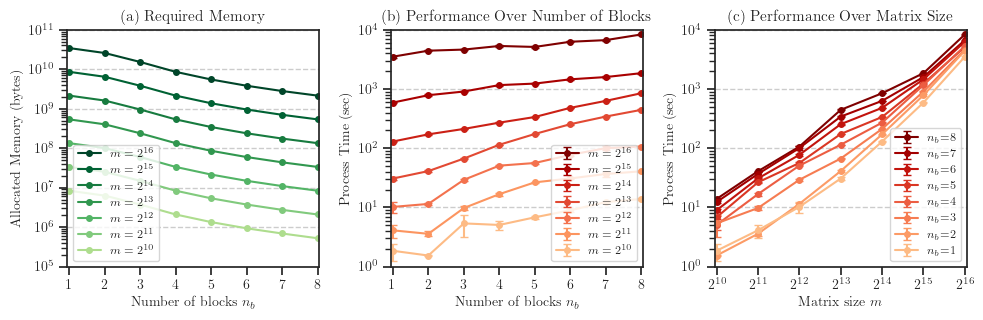

In [6]:
# Runtime

norm = matplotlib.colors.Normalize(vmin=-0.6, vmax=1.0)

fig, ax = plt.subplots(ncols=3, figsize=(10, 3.36))

# Font size
fs =10
fsl = 11
ms = 4

GB_scale = 1
num_lines = matrix_sizes.size
cmap = plt.colormaps.get_cmap('YlGn')
for i in range(matrix_sizes.size-1, -1, -1):
    n = matrix_sizes[i]
    nb = num_blocks
    m = numpy.floor((n - 1 + nb) / nb)
    mem_per_block = m**2 * 8
    ax[0].plot(num_blocks,
               numpy.mean(alloc_mem[i, :, :], axis=-1) * mem_per_block / GB_scale,
               '-o', markersize=ms, color=cmap(norm(i/(num_lines-1))),
               label=f'$m=2^{{{int(0.5+numpy.log2(matrix_sizes[i]))}}}$')

num_lines = matrix_sizes.size
cmap = plt.colormaps.get_cmap('OrRd')
for i in range(matrix_sizes.size-1, -1, -1):
    ax[1].errorbar(num_blocks,
                   numpy.mean(tot_proc_time[i, :, :], axis=-1),
                   yerr=numpy.std(tot_proc_time[i, :, :], axis=-1),
                   markersize=ms, capsize=3,
                   fmt='-o', color=cmap(norm(i/(num_lines-1))),
                   label=f'$m=2^{{{int(0.5+numpy.log2(matrix_sizes[i]))}}}$')

num_lines = num_blocks.size
cmap = plt.colormaps.get_cmap('OrRd')
for i in range(num_blocks.size-1, -1, -1):
    ax[2].errorbar(matrix_sizes,
                   numpy.mean(tot_proc_time[:, i, :], axis=-1),
                   yerr=numpy.std(tot_proc_time[:, i, :], axis=-1),
                   markersize=ms, capsize=3,
                   fmt='-o', color=cmap(norm(i/(num_lines-1))), label=f'$n_b$={num_blocks[i]}')


ax[0].set_xticks(num_blocks)
ax[1].set_xticks(num_blocks)
ax[2].set_xticks(matrix_sizes)

ax[0].set_xticklabels(ax[0].get_xticks(), fontsize=fs)
ax[1].set_xticklabels(ax[1].get_xticks(), fontsize=fs)
ax[2].set_xticklabels(ax[2].get_xticks(), fontsize=fs)

ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=fs)
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=fs)
ax[2].set_yticklabels(ax[2].get_yticks(), fontsize=fs)

ax[0].legend(fontsize='x-small', loc='lower left')
ax[1].legend(fontsize='x-small', loc='lower right')
ax[2].legend(fontsize='x-small')

ax[0].set_xlabel('Number of blocks $n_b$', fontsize=fs)
ax[1].set_xlabel('Number of blocks $n_b$', fontsize=fs)
ax[2].set_xlabel('Matrix size $m$', fontsize=fs)

ax[0].set_ylabel('Allocated Memory (bytes)', fontsize=fs)
ax[1].set_ylabel('Process Time (sec)', fontsize=fs)
ax[2].set_ylabel('Process Time (sec)', fontsize=fs)

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_xscale('log', base=2)
ax[2].set_yscale('log')

ticks = [2**i for i in map(int, 0.5+numpy.log2(matrix_sizes))]
ax[2].set_xticks(ticks, [f'$2^{{{i}}}$' for i in map(int, 0.5+numpy.log2(matrix_sizes))])

ax[0].set_xlim([num_blocks[0]-0.05, num_blocks[-1]+0.05])
ax[1].set_xlim([num_blocks[0]-0.05, num_blocks[-1]+0.05])
ax[2].set_xlim([matrix_sizes[0]/1.03, matrix_sizes[-1]*1.03])

ax[0].set_title('(a) Required Memory', fontsize=fsl)
ax[1].set_title('(b) Performance Over Number of Blocks', fontsize=fsl)
ax[2].set_title('(c) Performance Over Matrix Size', fontsize=fsl)

ax[0].grid(True, axis='y', which='major', ls='--')
ax[1].grid(True, axis='y', which='major', ls='--')
ax[2].grid(True, axis='y', which='major', ls='--')

ax[0].set_ylim([1e5, 1e11])
ax[1].set_ylim([1e0, 1e4])
ax[2].set_ylim([1e0, 1e4])

plt.tight_layout()

texplot.show_or_save_plot(plt, default_filename='performance.pdf', transparent_background=False,
                          dpi=200, show_and_save=True, verbose=True)

Plot saved to "/home/sia/work/github/detkit/benchmark/memdet/latency.pdf".


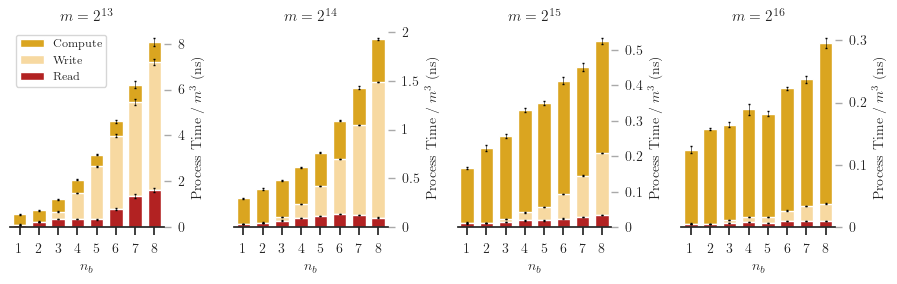

In [7]:
# Custom formatter to clean up y-ticks
def clean_formatter(x, pos):
    if abs(x) < 1e-5:  # Handle very small values
        return '0'
    elif x != round(x*1e5)/1e5:  # Handle values close to an integer
        return f'{int(x*1e5)/1e5}'.rstrip('0').rstrip('.')
    else:
        return f'{x:.2f}'.rstrip('0').rstrip('.')

norm = matplotlib.colors.Normalize(vmin=-0.5, vmax=1.0)

plots = [3, 4, 5, 6]
num_plots = len(plots)

fig, ax = plt.subplots(ncols=num_plots, figsize=(num_plots*2.3, 3))

# Font size
fs =10
fsl = 11
ms = 4

num_lines = matrix_sizes.size
cmap = plt.colormaps.get_cmap('Reds')

# Nano second
scale = 10e9

# for _ in range(matrix_sizes.size):
for i in range(num_plots):
    ii = plots[i]
    n = matrix_sizes[ii]
    load_mean = numpy.mean(scale * load_proc_time[ii, :, :] / (n**3), axis=-1)
    load_std = numpy.std(scale * load_proc_time[ii, :, :] / (n**3), axis=-1)
    store_mean = numpy.mean(scale * store_proc_time[ii, :, :] / (n**3), axis=-1)
    store_std = numpy.std(scale * store_proc_time[ii, :, :] / (n**3), axis=-1)
    tot_mean = numpy.mean(scale * tot_proc_time[ii, :, :] / (n**3), axis=-1)
    tot_std = numpy.std(scale * tot_proc_time[ii, :, :] / (n**3), axis=-1)

    width=0.7
    ax[i].bar(num_blocks, tot_mean, yerr=tot_std, bottom=0, color='goldenrod', width=width,
              label='Compute', error_kw={'capsize': 1, 'elinewidth': 0.4})
    ax[i].bar(num_blocks, store_mean, bottom=load_mean, yerr=store_std, color='#F7D9A1',
              width=width, label='Write', error_kw={'capsize': 1, 'elinewidth': 0.4})
    ax[i].bar(num_blocks, load_mean, yerr=load_std, bottom=0, color='firebrick', width=width,
              label='Read', error_kw={'capsize': 1, 'elinewidth': 0.4})

    ax[i].set_xticks(num_blocks)

    if i == 0:
        ax[i].legend(fontsize='x-small')
    ax[i].set_xlabel('$n_b$', fontsize=fs)
    ax[i].set_ylabel(r'Process Time / $m^3$ (ns)', fontsize=fs)
    
    
    ax[i].set_xlim([num_blocks[0]-0.5, num_blocks[-1]+0.5])
    
    ax[i].tick_params(axis='x', pad=6)
    
    # Remove axis spines except bottom spine
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    
    # Keep ticks and label to left
    ax[i].tick_params(axis='y',which='both', labelleft=False, labelright=True, color='darkgrey', pad=5)
    ax[i].yaxis.set_label_position("right")
    ax[i].yaxis.set_ticks_position('right')
    ax[i].yaxis.tick_right()
    ax[i].tick_params(axis='y',which='major',direction='out',width=1,length=5)

    ax[i].set_xticklabels(ax[i].get_xticks(), fontsize=fs)
    ax[i].set_yticklabels(ax[i].get_yticks(), fontsize=fs)

    ax[i].yaxis.set_major_formatter(FuncFormatter(clean_formatter))

    ax[i].set_title(r'$m=2^{%d}$' % int(0.5 + numpy.log2(matrix_sizes[ii])), fontsize=fsl)

plt.tight_layout()

texplot.show_or_save_plot(plt, default_filename='latency.pdf', transparent_background=False,
                          dpi=200, show_and_save=True, verbose=True)